## Bering Sea Bottom Temperature Comparisons: NEP Already Interpolated to Trawl Locations

In [85]:
import numpy as np
import pandas 
import datetime as dt
import scipy.stats
import matplotlib.dates as pltd
import matplotlib.pyplot as plt 

In [79]:
def convert_time(time):
    date_vals = np.zeros(len(time))
    for nt in range(len(df2)):
        day_time = dt.datetime.strptime((time[nt]+ ' 12'), '%d-%b-%y %H')
        date_vals[nt] = pltd.date2num(day_time)
            
    return date_vals

In [80]:
# Read in csv with both gear and nep mo6 bottom temperature
df2 = pandas.read_csv('NEP_MOM6_vs_Bering_trawl_bottom_temperature')
# How many NaN values 
df2.isna().sum()

LONGITUDE                  0
LATITUDE                   0
START_TIME                 0
GEAR_TEMPERATURE          37
YEAR                       0
NEP_BOTTOM_TEMPERATURE    43
dtype: int64

In [81]:
# remove rows with NaN
df2 = df2.dropna().reset_index()
nep_temp = df2['NEP_BOTTOM_TEMPERATURE']
trawl_temp = df2['GEAR_TEMPERATURE']
year =  df2['YEAR']
df2.isna().sum() # confirm NaNs removed

index                     0
LONGITUDE                 0
LATITUDE                  0
START_TIME                0
GEAR_TEMPERATURE          0
YEAR                      0
NEP_BOTTOM_TEMPERATURE    0
dtype: int64

MEAN BIAS: 0.6212242737957172 DegC
ROOT MEAN SQUARED ERROR: 1.3120310193553497 DegC
PEARSON CORRELATION COEFFICIENT: 0.877343810899177


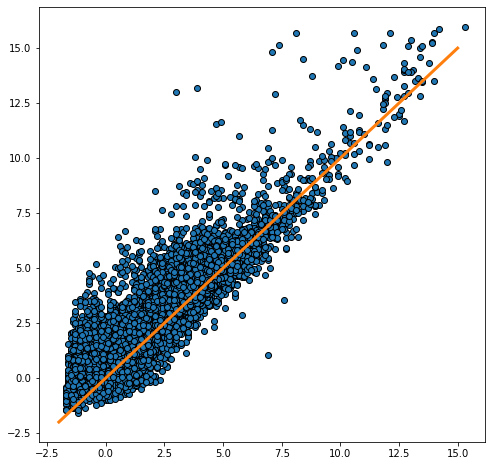

In [82]:
# ALL values 2003-2019
plt.figure(figsize=(8,8))
plt.plot(trawl_temp,nep_temp,'o',mec='k')
plt.plot((-2,15),(-2,15),linewidth=3)


print('MEAN BIAS:', np.mean(nep_temp-trawl_temp), 'DegC')
print('ROOT MEAN SQUARED ERROR:', np.sqrt(np.mean((nep_temp-trawl_temp)**2)), 'DegC')
print('PEARSON CORRELATION COEFFICIENT:', scipy.stats.pearsonr(trawl_temp, nep_temp)[0])


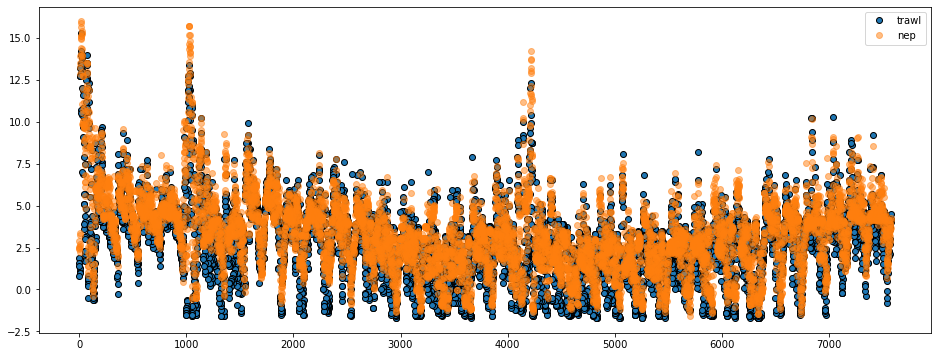

In [83]:
# Spread out, only sampling periods
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()

ax.plot(trawl_temp[::-1],'o',mec='k',label='trawl')
ax.plot(nep_temp[::-1],'o',alpha=.5,label='nep')
ax.legend()

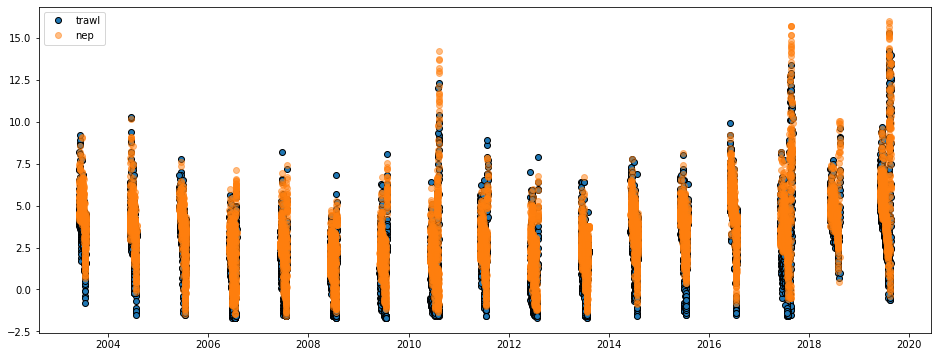

In [84]:
# Correct Time 
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()
plt_time = convert_time(df2['START_TIME'])

ax.plot(plt_time,trawl_temp,'o',mec='k',label='trawl')
ax.plot(plt_time,nep_temp,'o',alpha=.5,label='nep')
ax.legend()
ax.xaxis_date()

### Interpolation code. Only done once and then saved as csv file used above

In [ ]:
import matplotlib.pyplot as plt 
import pandas 
import numpy as np
import netCDF4 as nc
import xarray as xr
import xesmf
import datetime as dt

In [ ]:
# NEP Grid
nep_grd_fil = '/work/Liz.Drenkard/mom6/nep_10km/nep_grid.nc'
grd_fid = nc.Dataset(nep_grd_fil)

nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['depth'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

In [ ]:
# Only done once to save out csv file. This step is very slow ...
# There's probably a faster method but idk what it is. Parallelization?

excel_fil = '/work/Liz.Drenkard/external_data/Bering_Sea_bot_temp/AFSC_groundfish_survey_temperature_1982-2020.xlsx'
df = pandas.read_excel(excel_fil)
df = df.dropna(subset=['START_TIME'])
df = df[['LONGITUDE','LATITUDE','START_TIME','GEAR_TEMPERATURE']]

# Add column for year to eliminate dates not currently modeled
year_list = []
for nsamp in range(len(df)):
    year_list = np.append(year_list,dt.datetime.strptime(df['START_TIME'][nsamp], '%d-%b-%y').year)
df['YEAR'] = year_list

# drop rows that go back further than the model
df = df[df.YEAR >= 2003]

# add empty column for NEP temp
df['NEP_BOTTOM_TEMPERATURE'] = -9999 * np.ones(len(df))

# NEP multi-year file
nep_fil = '/work/Liz.Drenkard/mom6/nep_10km/output/nep_10km_era5/glorys_sponge/bgc/postproc/nep_tob_daily_2003-2019.nc'
nep_ds = xr.open_dataset(nep_fil)
nep_ds = nep_ds.assign_coords(lon = (('yh', 'xh'), nep_lon))
nep_ds = nep_ds.assign_coords(lat = (('yh', 'xh'), nep_lat))
    
trawl_locs = xr.Dataset()
for index, row in df.iterrows():
    if index%200 == 0:
        print(index) # Tracking progress
    trawl_locs['lon'] = xr.DataArray(data=[df['LONGITUDE'][index]], dims=('trawl_sample'))
    trawl_locs['lat'] = xr.DataArray(data=[df['LATITUDE'][index]], dims=('trawl_sample'))
    regridder = xesmf.Regridder(nep_ds, trawl_locs, 'bilinear', locstream_out=True)
    
    df['NEP_BOTTOM_TEMPERATURE'][index] = regridder(nep_ds['tob'].sel(time=dt.datetime.strptime((df['START_TIME'][index]+ ' 12'), '%d-%b-%y %H')))

df.to_csv('NEP_MOM6_vs_Bering_trawl_bottom_temperature', index=False)    